In [1]:
%%writefile load_imgs.py
import cv2
import numpy as np
def load_img(direct,file,size=100):
    pic = cv2.imread(direct+file)
    pic = cv2.resize(pic,(size,size))
    
    if "cat" in file:
        label = 0
    else:
        label = 1
    
    return [pic,label]


Writing load_imgs.py


In [2]:
from tqdm.notebook import tqdm



In [3]:
import time
start_time = time.time()
import numpy as np
import pandas as pd
from multiprocessing import Pool
from load_imgs import load_img



import cv2
import PIL
from os import listdir
import random

%matplotlib inline
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import accuracy_score, classification_report




randomSeed = 36

Loading the data

In [4]:
picSize = 100
img_to_load = [(r"data/dogs-vs-cats/train/",i,picSize) for i in listdir(r"data/dogs-vs-cats/train/")]
###########
random.shuffle(img_to_load)
img_to_load = img_to_load
############
p = Pool(processes=4)

out = p.starmap(load_img,img_to_load)


In [5]:
data = np.array([out[i][0] for i in range(len(out))])
target = [out[i][1] for i in range(len(out))]
out=None

Constructing an image transformation pipeline

We will add all our transformations into a single pipeline so we can apply all our transformations easly

In [6]:
class erode_img(BaseEstimator, TransformerMixin):
    def __init__(self,matrix=None, iterations=0,picSize=100):
        self.matrix = matrix
        self.picSize = picSize
        self.iterations=iterations
    def fit(self, Data, y=None):
        return self
    def transform(self,Data,y=None):
        newData = []
        if self.iterations > 0:
            for i in range(len(Data)):
                if Data[i].shape != (self.picSize,self.picSize) and Data[i].shape != (self.picSize,self.picSize,3):
                    newData.append(cv2.erode(Data[i].reshape(self.picSize,self.picSize,3),self.matrix,iterations=self.iterations))
                else:
                    newData.append(cv2.erode(Data[i],self.matrix,iterations=self.iterations))
            return newData
        return Data
    def inverse_transform(self,Data,y=None):
        return Data

In [7]:
class dilate_img(BaseEstimator, TransformerMixin):
    def __init__(self,matrix=None, iterations=0, picSize=100):
        self.matrix = matrix
        self.iterations=iterations
        self.picSize = picSize
    def fit(self, Data, y=None):
        return self
    def transform(self,Data, y=None):
        newData = []
        if self.iterations > 0:
            for i in range(len(Data)):
                if Data[i].shape != (self.picSize,self.picSize) and Data[i].shape != (self.picSize,self.picSize,3):
                    newData.append(cv2.dilate(Data[i].reshape(self.picSize,self.picSize,3),self.matrix,iterations=self.iterations))
                else:
                    newData.append(cv2.dilate(Data[i],self.matrix,iterations=self.iterations))
            return newData
        return Data
    def inverse_transform(self,Data,y=None):
        return Data

In [8]:
class grayScale(BaseEstimator, TransformerMixin):
    def __init__(self,picSize=100):
        self.picSize = picSize
    def fit(self, Data, y=None):
        return self
    def transform(self,Data, y=None):
        newData = []
        for i in range(len(Data)):
            if Data[i].shape != (self.picSize,self.picSize,3):
                newData.append(cv2.cvtColor(Data[i].reshape(self.picSize,self.picSize,3), cv2.COLOR_BGR2GRAY))
            else:
                newData.append(cv2.cvtColor(Data[i], cv2.COLOR_BGR2GRAY))
        return newData
    def inverse_transform(self,Data,y=None):
        return Data

In [9]:
class reShape(BaseEstimator, TransformerMixin):
    def __init__(self,picSize=100):
        self.picSize = picSize
    def fit(self, Data, y=None):
        return self

    def transform(self,Data, y=None):
        processed_data = np.array(Data)
        processed_data = np.array([a.flatten() for a in processed_data])
        return processed_data

    def inverse_transform(self, Data,y=None):
        newData = Data.copy()
        newData = newData.reshape(len(newData),self.picSize,self.picSize)
        return newData

In [10]:
class to_df(BaseEstimator, TransformerMixin):
    
    def fit(self, Data, y=None):
        return self

    def transform(self,Data, y=None):
        df = pd.DataFrame(Data)
        return df
    def inverse_transform(self, Data,y=None):
       
        newData = Data.to_numpy()
        return newData

First i will show what will be happening behind the scenes when we are using HalvingGridSearchCV to find the best paramaters.

we will use this as data for our non-optimized baseline model

The steps are as follows:

1. Transforming the images by bluring, dilating, eroding and gray scaling the images
2. Transforming the 2d image matrices to a 1d arrays in a data frame
3. Reducing the images dimension with pca and finding the best dimension
4. Finally inputing the data into the XGBoost model

 Step 1: Transforming the data

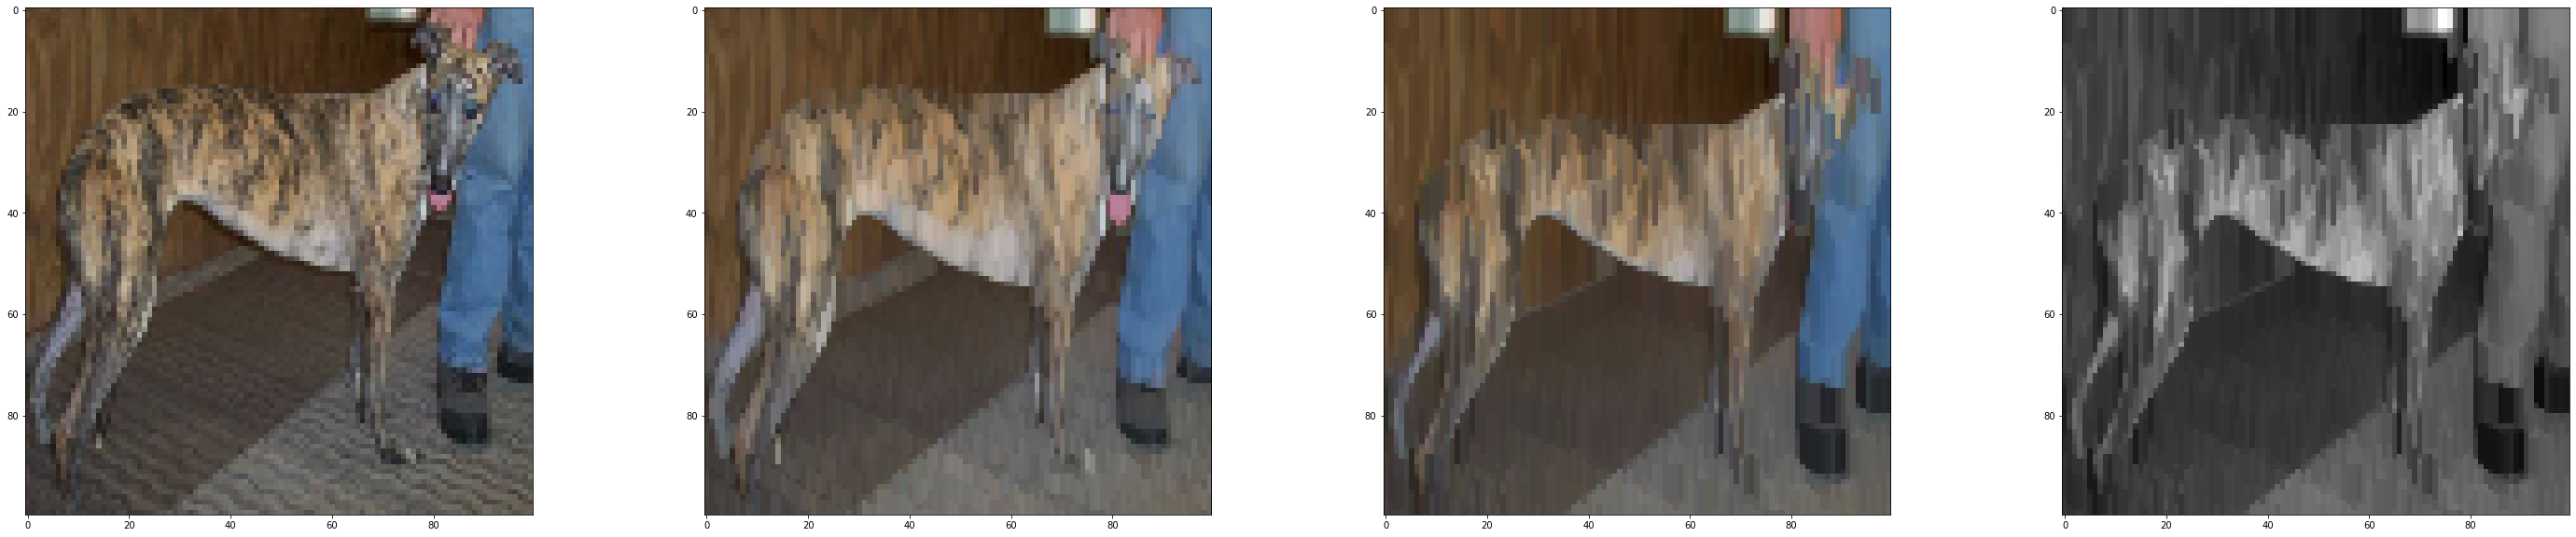

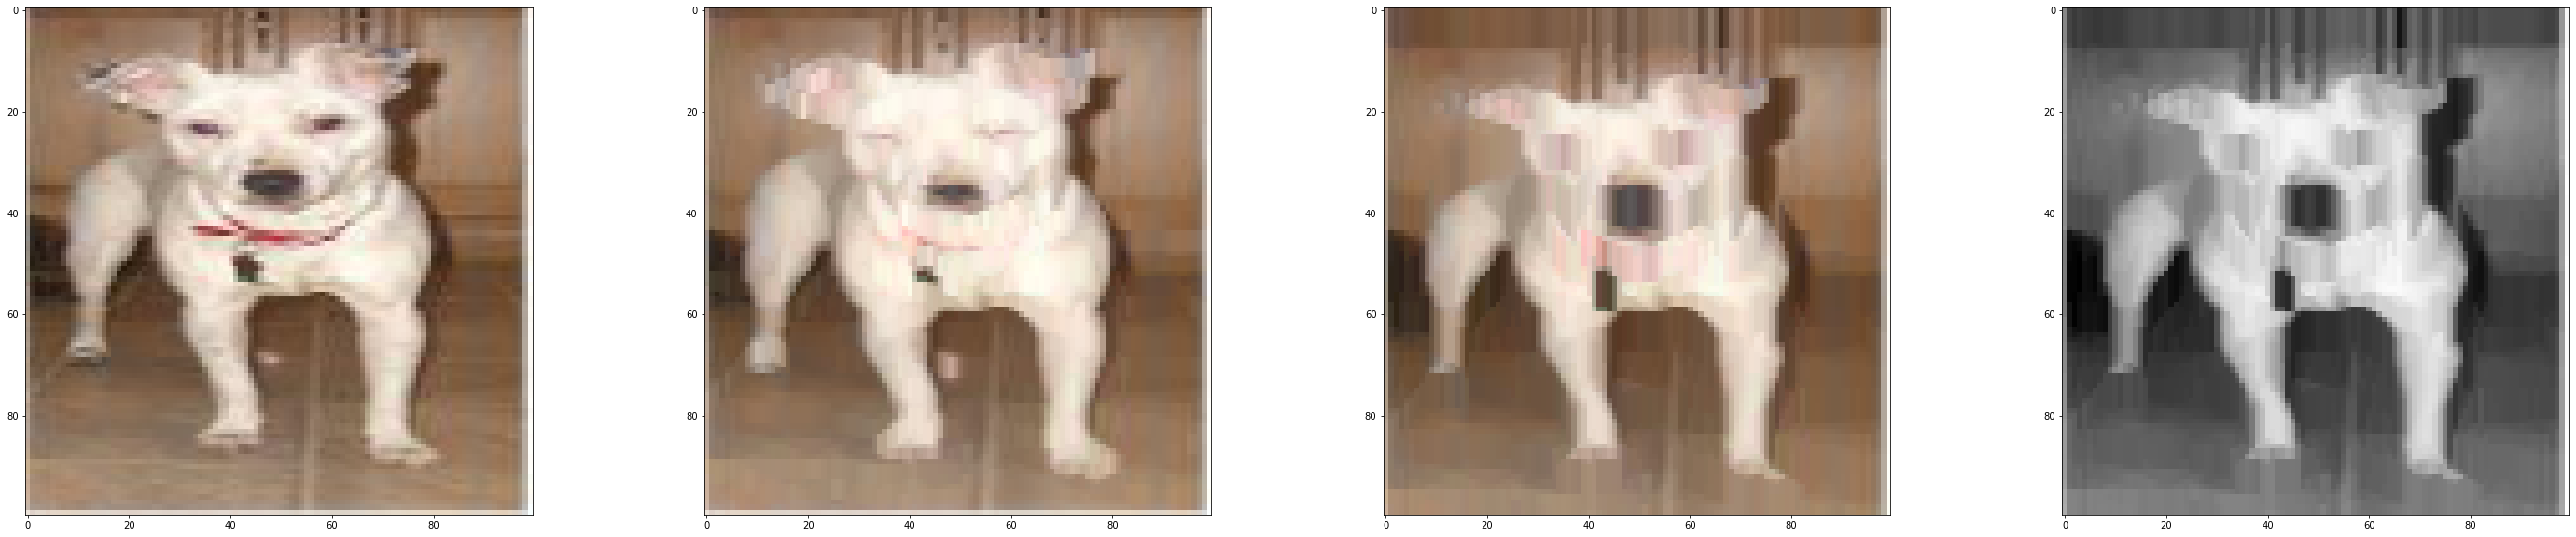

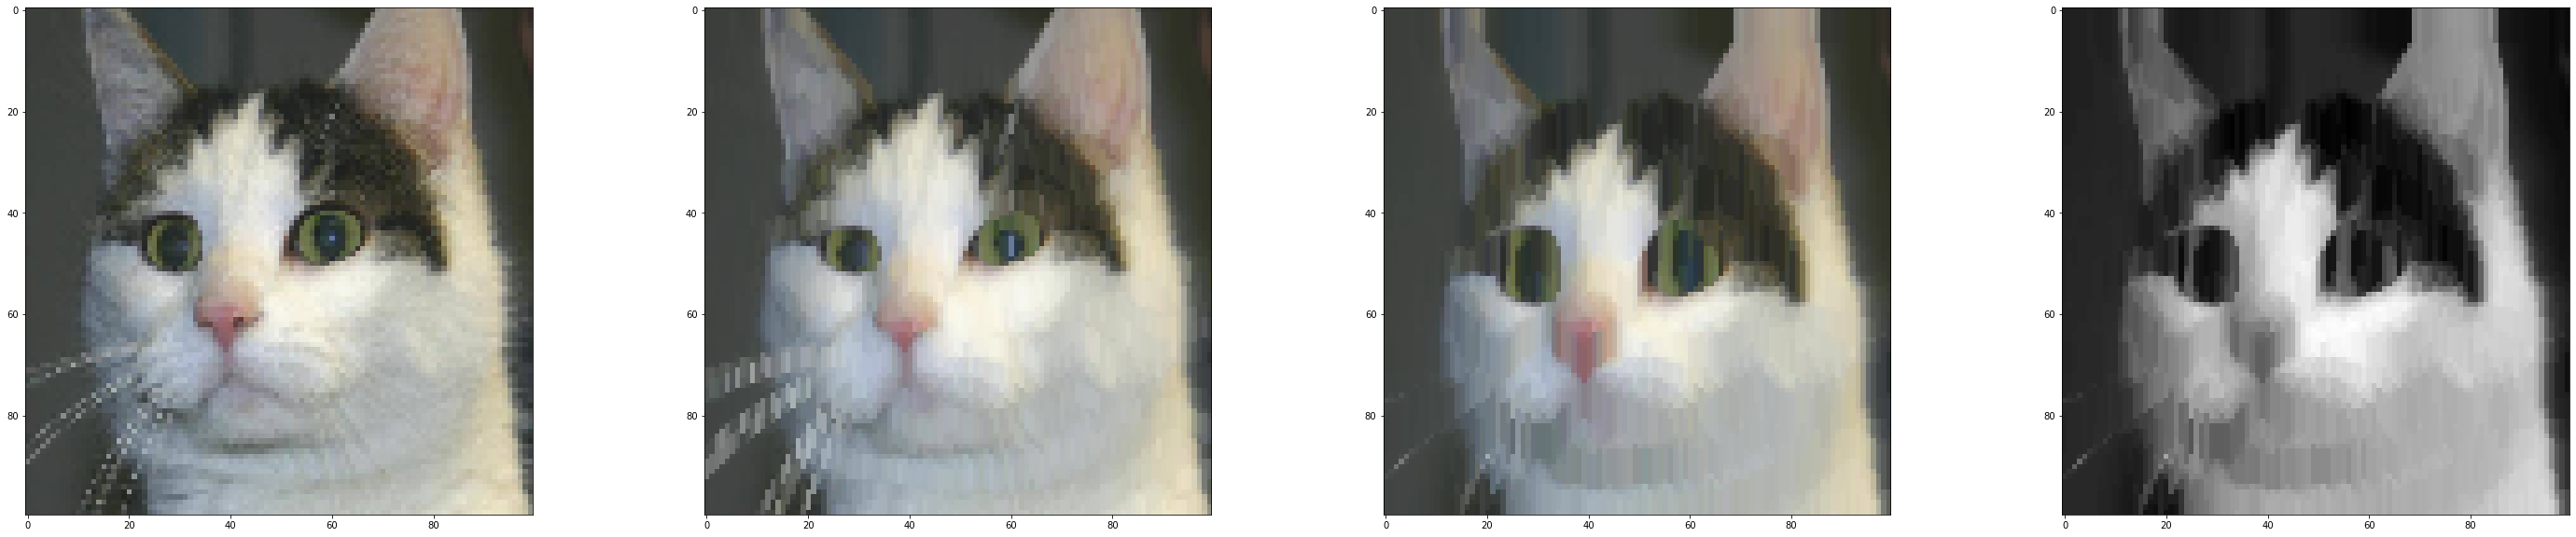

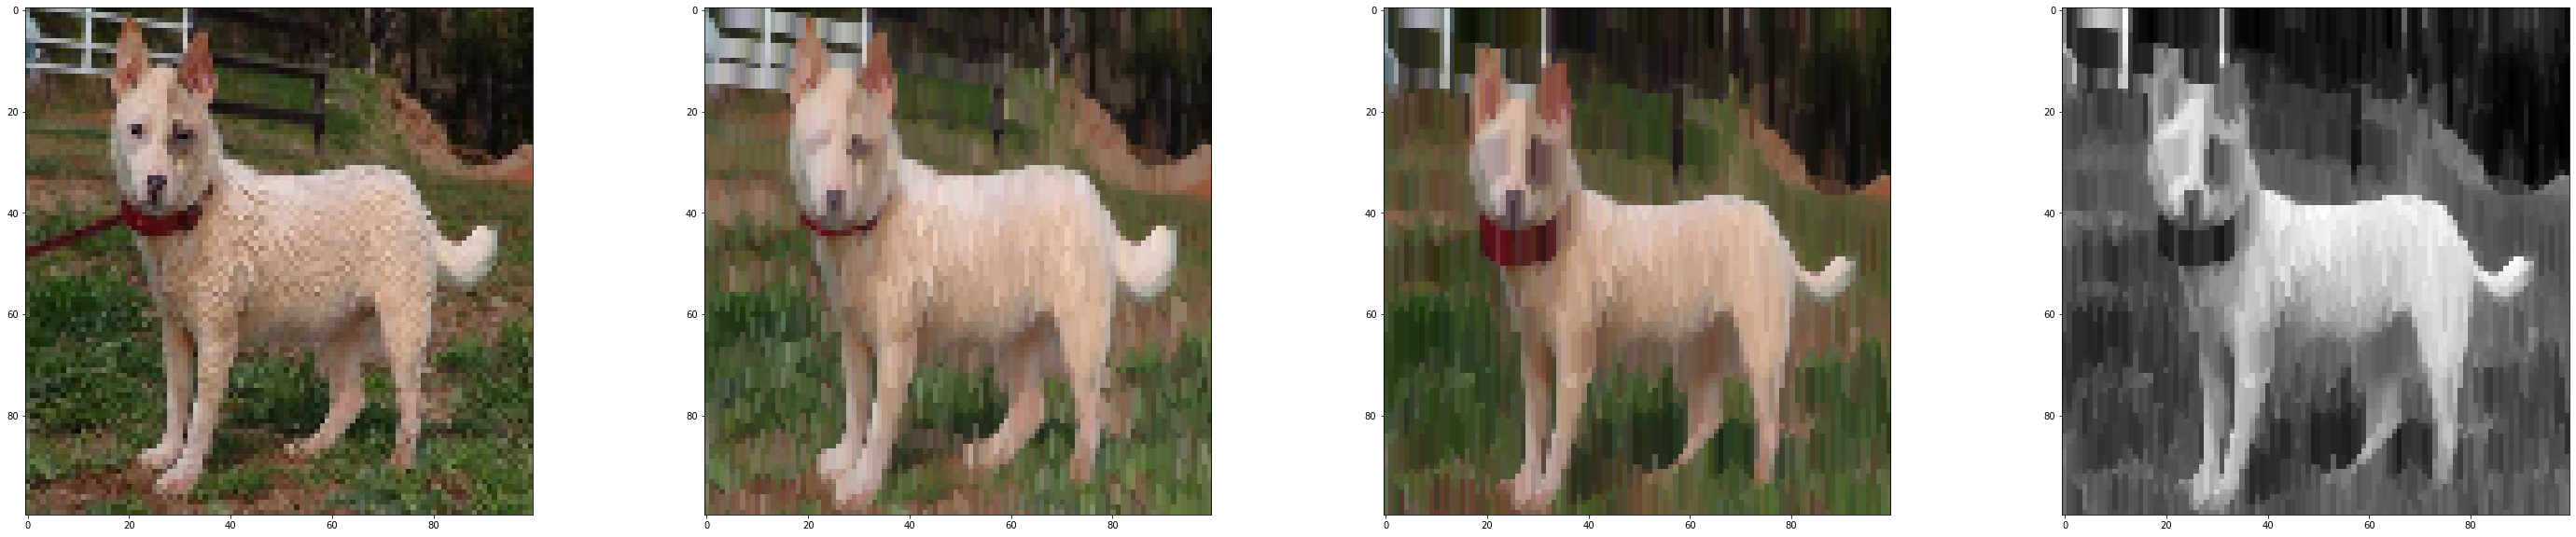

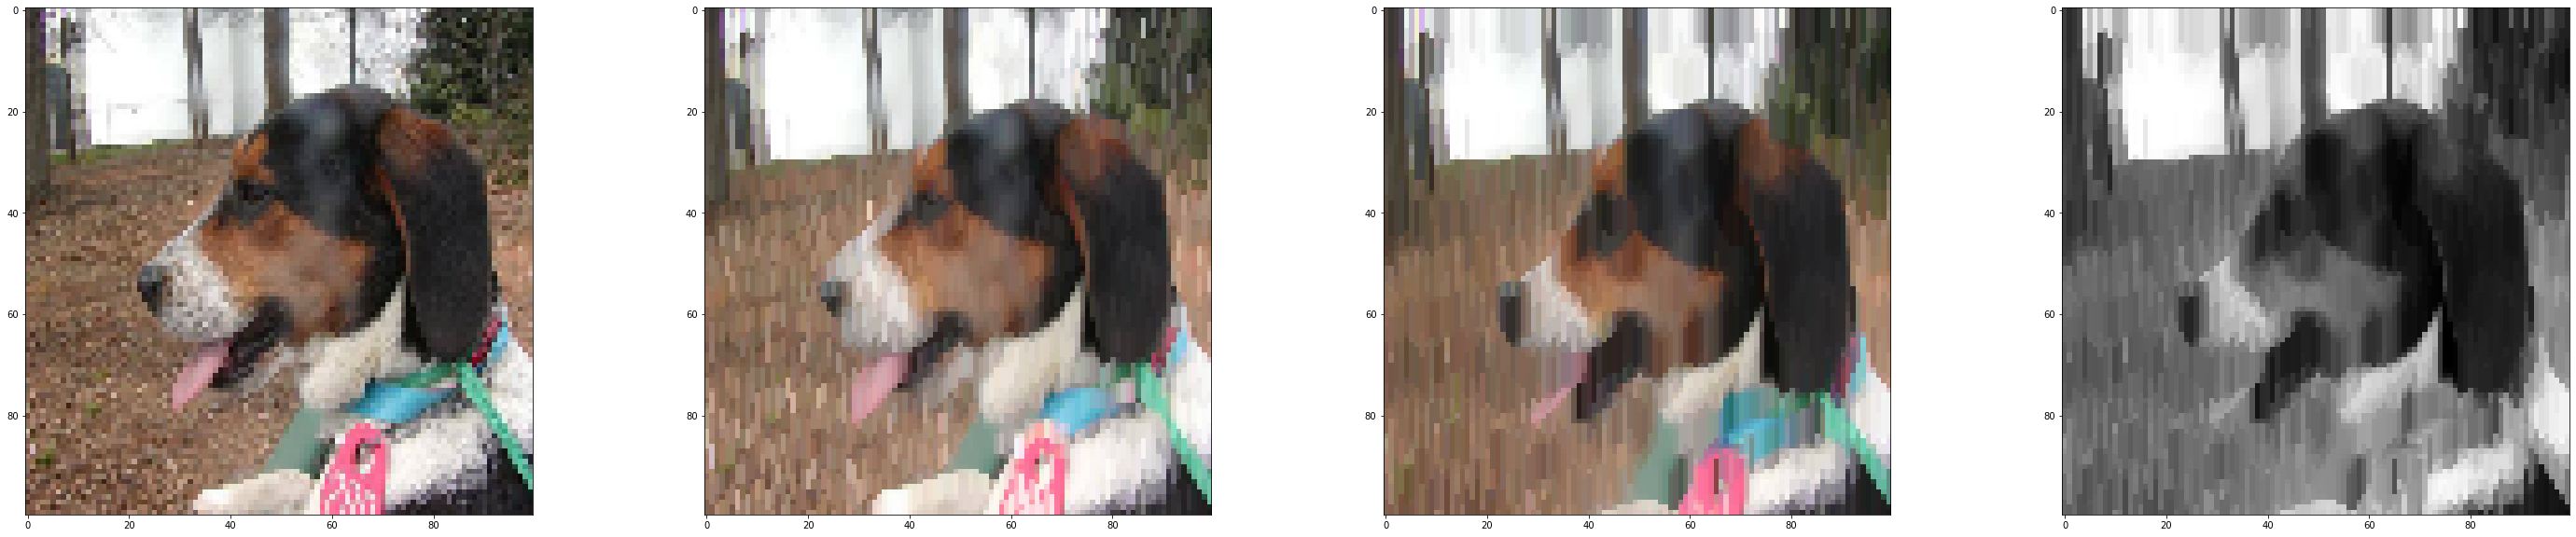

In [11]:
for i in range(5):
   
    dilated = cv2.dilate(data[i],(1,1),iterations=3)
    eroded = cv2.erode(dilated,(3,3),iterations=6)
    grayScaled = cv2.cvtColor(eroded, cv2.COLOR_BGR2GRAY)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(50,10)
    ax1.imshow(cv2.cvtColor(data[i],cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(dilated,cv2.COLOR_BGR2RGB))
    ax3.imshow(cv2.cvtColor(eroded,cv2.COLOR_BGR2RGB))
    ax4.imshow(grayScaled,cmap="gray")

Step 2: Constructing an image transformation pipeline


In [12]:
img_preprocessing = Pipeline([
    ("dilate",dilate_img(picSize=picSize)),
    ("erode",erode_img(picSize=picSize)),
    ("grayScale",grayScale(picSize=picSize)),
    ("reshape",reShape(picSize=picSize)),
    #("scaler",StandardScaler()),
    ("toDF", to_df())
])

Step 3: Reducing dimensions

We will now look for the optimal image transformations to get 95% feature variance with the least amount of features

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.reshape(len(data),picSize*picSize*3), target, test_size=0.25, random_state=randomSeed)

In [14]:
X_train_new = np.array([cv2.cvtColor(i.reshape(picSize,picSize,3), cv2.COLOR_BGR2GRAY) for i in X_train])
X_test_new = np.array([cv2.cvtColor(i.reshape(picSize,picSize,3), cv2.COLOR_BGR2GRAY) for i in X_test])
X_train_new = X_train_new.reshape((len(X_train_new),picSize*picSize))
X_test_new = X_test_new.reshape((len(X_test_new),picSize*picSize))
X_train_new.shape

(18750, 10000)

In [15]:
pca = PCA(random_state=randomSeed)
pca.fit(X_train_new)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)


Feature variance ratio without any transformations

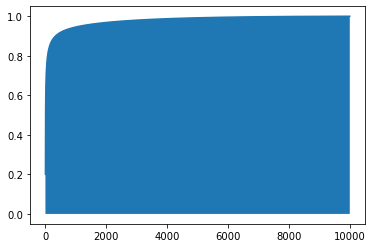

In [16]:
fig, ax = plt.subplots()
ax.plot(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul)
ax.fill_between(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul,0)

In [17]:
maxFeatures = len(exp_var_cumul[exp_var_cumul<0.95])
exp_var_cumul[maxFeatures], maxFeatures

(0.9500174466677003, 1130)

In [18]:
grid = {
    'dilate__matrix':[(5,5)],
    #'dilate__iterations':[0,3,6,9,15],
    'dilate__iterations':[9],
    'erode__matrix':[(5,5)],
    #'erode__iterations':[0,3,6,9,15],
    'erode__iterations':[9],
}
params = ParameterGrid(grid)

In [19]:
def get_best_transformations(params,threshold=0.95):    
    print("Testing",len(params),"combinations of paramaters")
    start = time.time()
    last_update = time.time()
    best_params = {
        'dilate__matrix':None,
        'dilate__iterations':None,
        'erode__matrix':None,
        'erode__iterations':None,
    }

    best_dim =  picSize**2
    with tqdm(total=len(params)) as pbar:
        for param in params:
            
            img_preprocessing.set_params(**param)
            X_train_new = img_preprocessing.fit_transform(X_train)
            pca = PCA(random_state=randomSeed)
            pca.fit(X_train_new)
            exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
            maxFeatures = len(exp_var_cumul[exp_var_cumul<threshold])
            if maxFeatures < best_dim:
                best_dim = maxFeatures
                best_params = param
            best_params["pca__n_components"] = best_dim
            if time.time() - last_update > 60:
                print(str((time.time()-start)/60)+"m elapsed")
                last_update = time.time()
            pbar.update(1)
    return best_params


In [20]:
params = get_best_transformations(params,threshold=0.95)


Testing 81 combinations of paramaters


  0%|          | 0/81 [00:00<?, ?it/s]

4.453407402833303m elapsed
8.892697370052337m elapsed
13.374920090039572m elapsed
17.859406447410585m elapsed
22.347574575742087m elapsed
26.83180457353592m elapsed
31.31118108431498m elapsed
35.785961035887404m elapsed
40.258571549256644m elapsed
44.74202034870783m elapsed
49.22784854968389m elapsed
53.711579247315726m elapsed
58.194823773701984m elapsed
62.67394473950068m elapsed
67.14047598838806m elapsed
71.59300614992777m elapsed
76.04077002207438m elapsed
80.48501385847727m elapsed
84.94616365035375m elapsed
89.40988861719767m elapsed
93.86395828723907m elapsed
98.312457772096m elapsed
102.77315316597621m elapsed
107.23157634337743m elapsed
111.70111972093582m elapsed
116.17297172546387m elapsed
120.64360518455506m elapsed
125.11260776917139m elapsed
129.57005471785862m elapsed
134.02532477378844m elapsed
138.47975004514058m elapsed
142.9367221514384m elapsed
147.39560488065084m elapsed
151.8771638671557m elapsed
156.36213972965876m elapsed
160.84672917524975m elapsed
165.3239354

In [21]:
pipe = Pipeline([
    ("dilate",dilate_img(picSize=picSize)),
    ("erode",erode_img(picSize=picSize)),
    ("grayScale",grayScale(picSize=picSize)),
    ("reshape",reShape(picSize=picSize)),
    #("scaler",StandardScaler()),
    ("pca",PCA(random_state=randomSeed)),
    ("toDF", to_df())
    
],verbose=True)

pipe.set_params(**params)


Pipeline(steps=[('dilate', dilate_img(iterations=9, matrix=(5, 5))),
                ('erode', erode_img(iterations=9, matrix=(5, 5))),
                ('grayScale', grayScale()), ('reshape', reShape()),
                ('pca', PCA(n_components=305, random_state=36)),
                ('toDF', to_df())],
         verbose=True)

In [22]:
X_train_new = pipe.fit_transform(X_train)
X_test_new = pipe.transform(X_test)

[Pipeline] ............ (step 1 of 6) Processing dilate, total=   0.3s
[Pipeline] ............. (step 2 of 6) Processing erode, total=   0.4s
[Pipeline] ......... (step 3 of 6) Processing grayScale, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing reshape, total=   0.2s
[Pipeline] ............... (step 5 of 6) Processing pca, total=  13.1s
[Pipeline] .............. (step 6 of 6) Processing toDF, total=   0.0s


In [23]:
X_train_new.head(5)

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,300,301,302,303,304
0,-638.205624,-2103.738995,1046.662091,417.795664,497.677482,-424.807543,-962.506531,793.636161,1073.157912,-330.366159,...,22.049204,-14.072868,-107.439195,22.551262,-42.907535,-93.206108,-36.263126,35.308258,38.790137,-5.152078
1,160.998627,-618.038482,-1518.876146,2236.119817,-1964.011649,422.873074,-1553.038089,194.054746,402.248924,-438.722552,...,4.574586,-42.023129,157.306465,3.655166,-14.078482,77.822064,72.012415,102.784240,36.320457,-40.559420
2,-119.837397,-1205.100447,-392.179388,572.951254,4.091025,-171.455424,-595.258487,1172.162257,483.671001,-323.628457,...,-0.060899,-22.203715,-117.084929,7.457089,21.986306,-52.963768,27.295160,-6.504029,94.609126,-3.539892
3,2873.034454,-1739.542619,973.718014,1509.431703,-455.714217,-580.705982,843.788386,-106.283821,-583.480568,181.760198,...,-12.733148,82.082003,9.356175,12.344660,-42.114543,21.554351,-27.992452,32.189523,24.140859,-18.107118
4,2872.739445,2373.844133,-3073.421734,884.582009,176.490876,-2681.211756,1054.015349,22.510603,-90.824183,-634.596285,...,-71.696900,20.917736,-170.672189,-47.044708,-103.893330,-71.451774,27.971234,-60.787765,13.319731,3.012361


Image before and after transformations

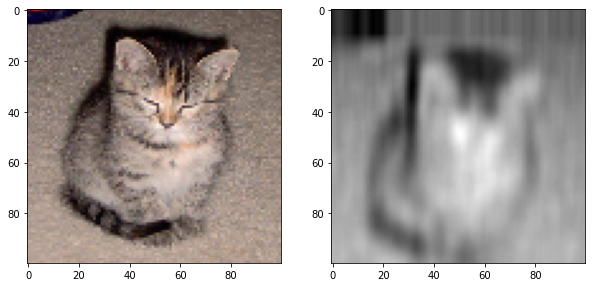

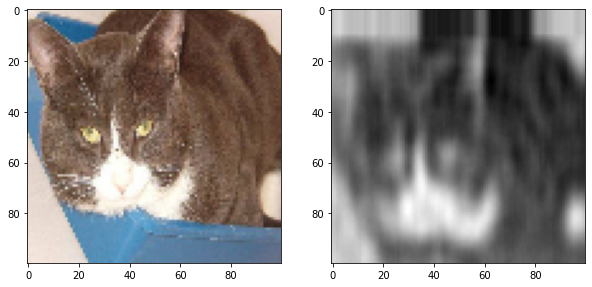

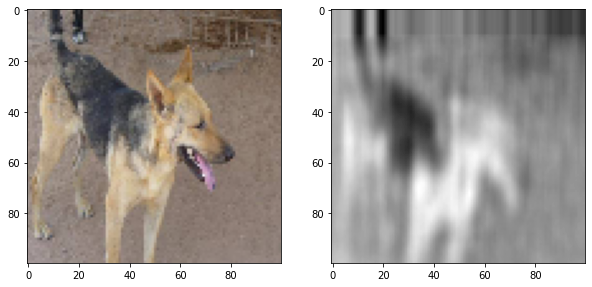

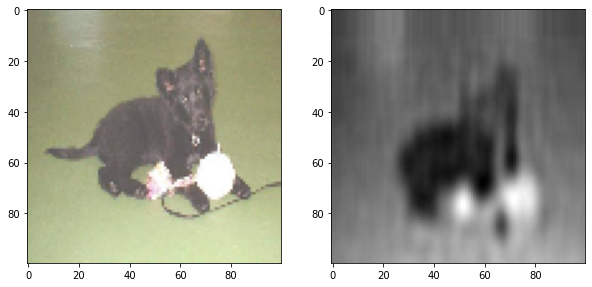

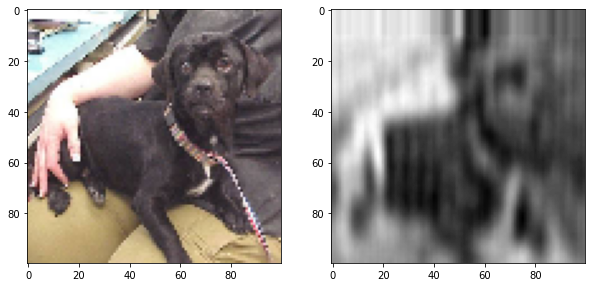

In [24]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10,5)
    img = X_train[i].reshape(picSize,picSize,3)
    ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    pca = PCA(random_state=randomSeed,)
    img = pipe.inverse_transform(X_train_new)[i]
    
    ax2.imshow(img.reshape((picSize,picSize)),cmap="gray")
    img = None

Step 4: creating our XGBoost model

This will act as a baseline model and we will try to improve it

In [25]:
def plot_model_results(model,X,y):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    cm = plot_confusion_matrix(model,X,y,display_labels=["cat","dog"],values_format="d",ax=ax1)
    fig.set_size_inches(20,10)
    num = cm.text_[0][0].get_text()
    txt = "True Negative"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[0][0].set_text(txt)
    
    num = cm.text_[1][0].get_text()
    txt = "False Negative"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[1][0].set_text(txt)

    num = cm.text_[0][1].get_text()
    txt = "False Positive"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[0][1].set_text(txt)

    num = cm.text_[1][1].get_text()
    txt = "True Positive"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[1][1].set_text(txt)
    
    falsePosRate, truePosRate, _ = roc_curve(y,np.random.choice([0,1],size=len(y_test)))
    plot_roc_curve(model,X,y,ax=ax2)
    ax2.plot(falsePosRate, truePosRate, linestyle='--')

In [26]:
baseline = xgb.XGBClassifier(n_estimators = 200, seed=randomSeed,tree_method='hist',eval_metric="mae")
baseline.fit(X_train_new,y_train)
baseline_prediction = baseline.predict(X_test_new)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [27]:
print("Accuracy:",accuracy_score(y_test,baseline_prediction))
print(classification_report(y_test,baseline_prediction))


Accuracy: 0.63216
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      3159
           1       0.62      0.64      0.63      3091

    accuracy                           0.63      6250
   macro avg       0.63      0.63      0.63      6250
weighted avg       0.63      0.63      0.63      6250



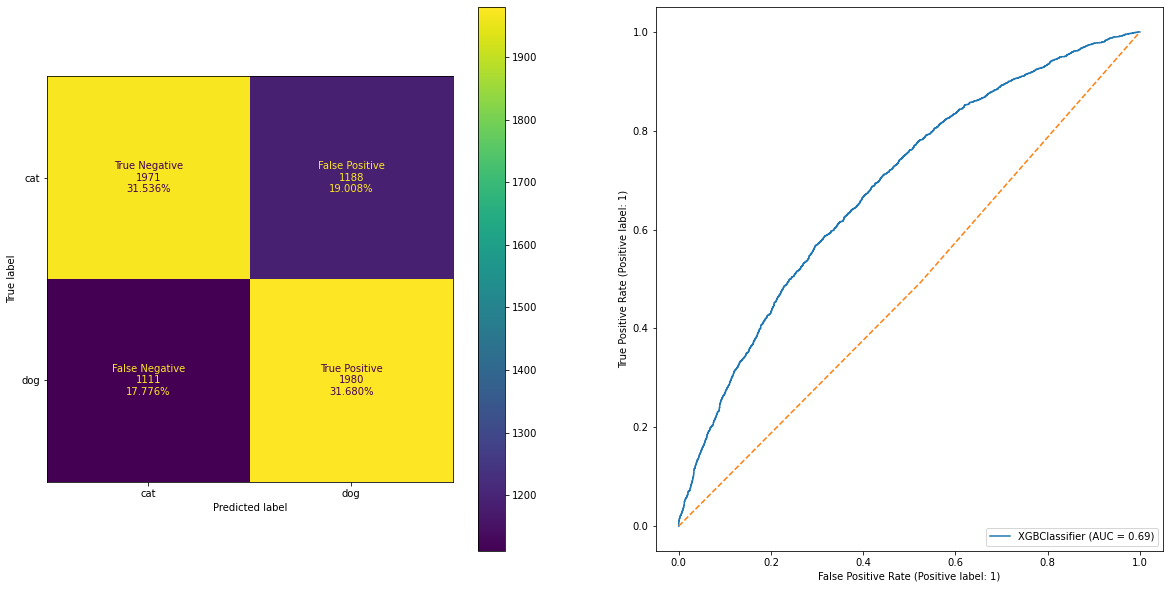

In [28]:
plot_model_results(baseline,X_test_new,y_test)

In [29]:
#train_scoreNum, test_scoreNum = validation_curve(AdaBoostClassifier(random_state=randomSeed), X = X_train_new, y = y_train, param_name = 'n_estimators', param_range = [200,600,800,1200], cv = 5, n_jobs=-1, verbose = 1)

In [30]:
#train_score_mean = np.mean(train_scoreNum,axis=1)
#train_score_std = np.std(train_scoreNum,axis=1)
#test_score_mean = np.mean(test_scoreNum,axis=1)
#test_score_std= np.std(test_scoreNum,axis=1)
#plt.semilogx([200,600,800,1200],train_score_mean)
#plt.fill_between([200,600,800,1200],train_score_mean-train_score_std,train_score_mean+train_score_std, alpha=0.2)
#plt.semilogx([200,600,800,1200],test_score_mean)
#plt.fill_between([200,600,800,1200],test_score_mean-test_score_std,test_score_mean+test_score_std, alpha=0.2)
#plt.show()

Step 5: paramater tuning

In [31]:
def param_search(param_grid,train,test,train_labels,test_labels,num_class=2,randomSeed=randomSeed,nfolds=5,eval_method="mae",higher_better=False,num_boost_round=10000,early_stopping_rounds=100,verbose=True):
    done = 0
    amount = len(param_grid)
    params = {
        'random_state':randomSeed,
        'eval_metric':eval_method,
    }
    start = time.time()
    timer = time.time()
    if higher_better: 
        best_eval = -float("inf")
    else:
        best_eval = float("inf")
    best_eval_train = 0
    best_params = {}
    best_iter = 0
    best_out = ''
    with tqdm(total=len(param_grid)) as pbar:
        for p in param_grid:
            out = ''
            for key in p:
                params[key] = p[key]
                out += key + '=' + str(p[key])+', '
            out = out[:-2]
            
            results = xgb.cv(params,train,num_boost_round=num_boost_round,nfold=nfolds,metrics={eval_method},early_stopping_rounds=early_stopping_rounds,seed=randomSeed)
            
            done +=1 
            #get mean score of cv of the training and testing, and get the best iteration
            mean_eval_test = results['test-'+eval_method+'-mean'].min()
            mean_eval_train = results['test-'+eval_method+'-mean'].min()
            iteration = results['test-'+eval_method+'-mean'].argmin()
            
            #update best parameters
            if (mean_eval_test < best_eval and higher_better==False) or (mean_eval_test > best_eval and higher_better):
                best_eval = mean_eval_test
                best_eval_train = mean_eval_train
                best_out = ''
                best_iter = iteration
                for key in p:
                    best_out += key + '=' + str(p[key])+', '
                    best_params[key] = p[key]
                best_out = best_out[:-2]

            #show results of cv
            if verbose:
                print("Parameters: "+out)
                print("Mean train "+eval_method+": "+str(mean_eval_train) + " Mean test "+eval_method+": "+str(mean_eval_test) + " Iteration: "+str(iteration))
                print(str(done)+"/"+str(amount))
                
                if (time.time()-timer) > 300:
                    print(str((time.time()-start)/60) +"m elapsed. Finished "+str(100*done/amount)+"%" )
                    timer = time.time()
                print("")
            pbar.update(1)
    stop = time.time()
    if verbose:
        print("----------------------------------------")
    print(f"Tuning time: {(time.time()-start)}s")
    print("Best parameters: "+best_out+":")
    print("Best mean train "+eval_method+": "+str(best_eval_train) + " Best mean test "+eval_method+": "+str(best_eval) + " Best iteration: "+str(iteration))
    
    #show accuracy score
    bst = xgb.train(dict({'random_state':randomSeed,'eval_metric':eval_method,'num_class':num_class},**best_params), train, best_iter+1)
    test_preds = bst.predict(test)
    train_preds = bst.predict(train)

    print("Test accuracy:",accuracy_score(test_labels,test_preds),"Train accuracy:",accuracy_score(train_labels,train_preds))
    return best_params,best_iter+1

In [32]:
dtrain = xgb.DMatrix(X_train_new, label=y_train)
dtest = xgb.DMatrix(X_test_new, label=y_test)

In [33]:
params = {
    'tree_method':'hist',
    'n_jobs':-1
}

In [34]:
grid = [
    dict({'learning_rate':lr},**params) 
    for lr in [0.1,0.3,0.5,0.7]
]

In [35]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

  0%|          | 0/4 [00:00<?, ?it/s]

Parameters: learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.4364504 Mean test mae: 0.4364504 Iteration: 1698
1/4
10.299434645970662m elapsed. Finished 25.0%

Parameters: learning_rate=0.3, tree_method=hist, n_jobs=-1
Mean train mae: 0.44105180000000005 Mean test mae: 0.44105180000000005 Iteration: 661
2/4

Parameters: learning_rate=0.5, tree_method=hist, n_jobs=-1
Mean train mae: 0.45407640000000005 Mean test mae: 0.45407640000000005 Iteration: 29
3/4

Parameters: learning_rate=0.7, tree_method=hist, n_jobs=-1
Mean train mae: 0.45846780000000004 Mean test mae: 0.45846780000000004 Iteration: 10
4/4
15.729520380496979m elapsed. Finished 100.0%

----------------------------------------
Tuning time: 943.7730033397675s
Best parameters: learning_rate=0.1, tree_method=hist, n_jobs=-1:
Best mean train mae: 0.4364504 Best mean test mae: 0.4364504 Best iteration: 10
Test accuracy: 0.66384 Train accuracy: 1.0


In [36]:
grid = [
    dict({'max_depth':i,'min_child_weight':j},**params)
    for i in [1,6,9]
    for j in [1,5,10]
]

In [37]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

  0%|          | 0/9 [00:00<?, ?it/s]

Parameters: max_depth=1, min_child_weight=1, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.44713520000000007 Mean test mae: 0.44713520000000007 Iteration: 7391
1/9
5.443630448977152m elapsed. Finished 11.11111111111111%

Parameters: max_depth=1, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.44713520000000007 Mean test mae: 0.44713520000000007 Iteration: 7391
2/9
10.863033962249755m elapsed. Finished 22.22222222222222%

Parameters: max_depth=1, min_child_weight=10, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.44713520000000007 Mean test mae: 0.44713520000000007 Iteration: 7391
3/9
16.285059344768523m elapsed. Finished 33.333333333333336%

Parameters: max_depth=6, min_child_weight=1, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.4364504 Mean test mae: 0.4364504 Iteration: 1698
4/9
26.598495399951936m elapsed. Finished 44.44444444444444%

Parameters: max_depth=6, min_child_weight=5, learning_r

In [38]:
grid = [
    dict({'gamma':g},**params) 
    for g in [0,1,3,5]
]

In [39]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

  0%|          | 0/4 [00:00<?, ?it/s]

Parameters: gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.4359547999999999 Mean test mae: 0.4359547999999999 Iteration: 1439
1/4
8.659003520011902m elapsed. Finished 25.0%

Parameters: gamma=1, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.445496 Mean test mae: 0.445496 Iteration: 174
2/4

Parameters: gamma=3, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.45821199999999995 Mean test mae: 0.45821199999999995 Iteration: 87
3/4

Parameters: gamma=5, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.47075680000000003 Mean test mae: 0.47075680000000003 Iteration: 41
4/4

----------------------------------------
Tuning time: 686.1064538955688s
Best parameters: gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1:
Best mean train mae: 0.43595479999

In [40]:
grid = [
    dict({'subsample':i,'colsample_bytree':j},**params) 
    for i in [0.7,0.8,0.9,1]
    for j in [0.7,0.8,0.9,1]
]

In [41]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

  0%|          | 0/16 [00:00<?, ?it/s]

Parameters: subsample=0.7, colsample_bytree=0.7, gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.4365672 Mean test mae: 0.4365672 Iteration: 853
1/16

Parameters: subsample=0.7, colsample_bytree=0.8, gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.4375008 Mean test mae: 0.4375008 Iteration: 1078
2/16
9.771936337153116m elapsed. Finished 12.5%

Parameters: subsample=0.7, colsample_bytree=0.9, gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.4382498 Mean test mae: 0.4382498 Iteration: 787
3/16

Parameters: subsample=0.7, colsample_bytree=1, gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.435682 Mean test mae: 0.435682 Iteration: 968
4/16
20.201545091470084m elapsed. Finished 25.0%

Parameters: subsample=0.8, colsample_bytree=0.7, gamma=0, max_depth=6, min_c

In [42]:
grid = [
    dict({'reg_lambda':i},**params) 
    for i in [1,5,10,15,20,25]
]

In [43]:
params,estimators = param_search(grid,dtrain,dtest,y_train,y_test)

  0%|          | 0/6 [00:00<?, ?it/s]

Parameters: reg_lambda=1, subsample=1, colsample_bytree=0.7, gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.4353682 Mean test mae: 0.4353682 Iteration: 1295
1/6
6.2099917451540625m elapsed. Finished 16.666666666666668%

Parameters: reg_lambda=5, subsample=1, colsample_bytree=0.7, gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.43607440000000003 Mean test mae: 0.43607440000000003 Iteration: 1920
2/6
14.841127403577168m elapsed. Finished 33.333333333333336%

Parameters: reg_lambda=10, subsample=1, colsample_bytree=0.7, gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mean train mae: 0.4350052 Mean test mae: 0.4350052 Iteration: 1188
3/6
20.62559061050415m elapsed. Finished 50.0%

Parameters: reg_lambda=15, subsample=1, colsample_bytree=0.7, gamma=0, max_depth=6, min_child_weight=5, learning_rate=0.1, tree_method=hist, n_jobs=-1
Mea

In [44]:
xgb_model = xgb.XGBClassifier(n_estimators = estimators, random_state=randomSeed,**params,eval_metric="auc")

In [45]:
xgb_model.fit(X_train_new,y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=1434, n_jobs=-1,
              num_parallel_tree=1, random_state=36, reg_alpha=0, reg_lambda=20,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              validate_parameters=1, verbosity=None)

In [47]:
pred_xgb = xgb_model.predict(X_test_new)

In [48]:
print("Accuracy:",accuracy_score(y_test,pred_xgb))
print(classification_report(y_test,pred_xgb))

Accuracy: 0.66304
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      3159
           1       0.66      0.67      0.66      3091

    accuracy                           0.66      6250
   macro avg       0.66      0.66      0.66      6250
weighted avg       0.66      0.66      0.66      6250



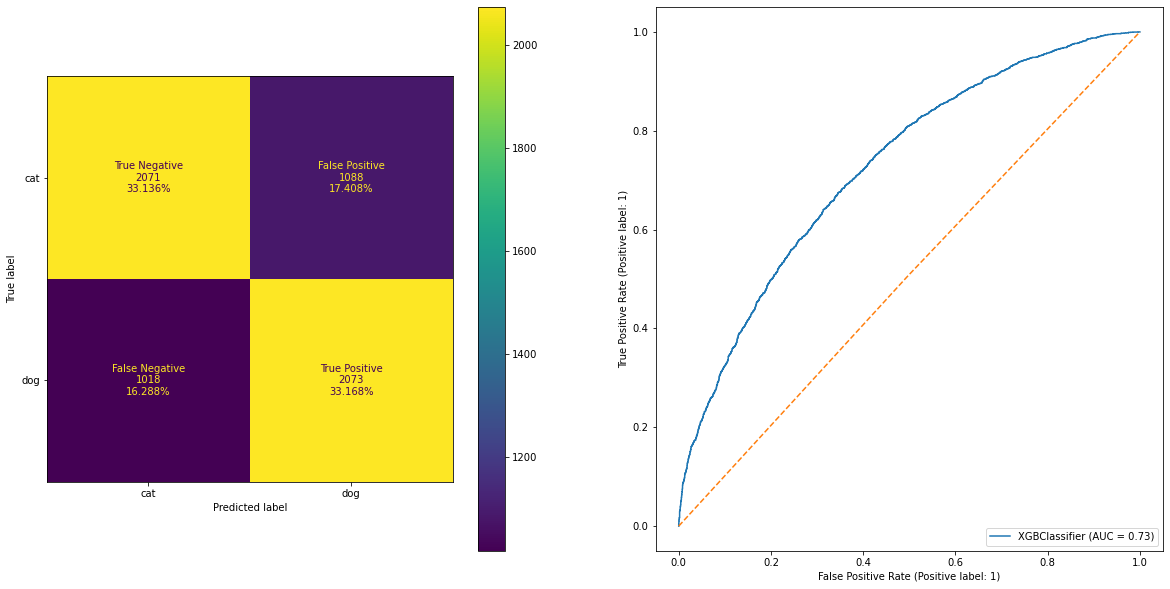

In [50]:
plot_model_results(xgb_model,X_test_new,y_test)

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
#voting = VotingClassifier(estimators=[('adaBoost',model),('randomForest',clf),('xgb',xgb_model)],n_jobs=-1,verbose=1,voting='soft')
#voting.fit(X_train_new,y_train)

In [ ]:
#pred3 = voting.predict(X_test_new)

In [ ]:
#print("Accuracy:",accuracy_score(y_test,pred3))
#print(classification_report(y_test,pred3))

In [ ]:
#plot_confusion_matrix(voting,X_test_new,y_test,display_labels=["cat","dog"],values_format="d")


In [ ]:
#plot_roc_curve(voting,X_test_new,y_test)

In [ ]:
end_time = time.time()
e = end_time-start_time


In [ ]:
print('{:0.0f}:{:0.0f}:{:0.0f}'.format(e // 3600, (e % 3600 // 60), e % 60))